## Importing Libraries

In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

In [3]:
import seaborn as sns

## Reading in data from pkl file

In [25]:
df1 = pd.read_pickle('../Data/Finale.pkl')
df = pd.read_pickle('../Data/working_dataset_v3.pkl')
# df.to_pickle('Data/Finale.pkl')

In [26]:
print(df1.columns)
print(df.columns)
print(df.shape)
# print(df.isna().sum())

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent', 'is_root',
       'is_selftext', 'word_counts', 'epoch_time', 'no_of_past_comments',
       'score_till_now', 'parent_cosine', 'parent_euc', 'cosine_euc',
       'title_cosine', 'title_euc', 'no_of_quoted_users', 'hour_of_comment',
       'weekday', 'title_url_in_top'],
      d

Let's drop comments that have NaN title_cosine because it means the words didn't have embeddings. Let's impute other missing values.

In [27]:
df = df[~df.title_cosine.isna()]
print(df.shape)
parent_scrore_impute = df.parent_score.mode()[0]
print(parent_scrore_impute)
comment_tree_root_score_impute = df.comment_tree_root_score.mode()[0]
print(comment_tree_root_score_impute)
time_since_comment_tree_root_impute = df.time_since_comment_tree_root.mode()[0]
print(time_since_comment_tree_root_impute)
parent_cosine_impute = 0
parent_euc_impute = 0
df.loc[df.parent_score.isna(), 'parent_score'] = parent_scrore_impute
df.loc[df.comment_tree_root_score.isna(), 'comment_tree_root_score'] = comment_tree_root_score_impute
df.loc[df.time_since_comment_tree_root.isna(), 'time_since_comment_tree_root'] = time_since_comment_tree_root_impute
df.loc[df.parent_cosine.isna(), 'parent_cosine'] = parent_cosine_impute
df.loc[df.parent_euc.isna(), 'parent_euc'] = parent_euc_impute

(1205039, 62)
1.0
1.0
0.0


In [53]:
print(df.isna().sum())

created_utc                          0
ups                                  0
subreddit_id                         0
link_id                              0
name                                 0
score_hidden                         0
author_flair_css_class          858984
author_flair_text               856356
subreddit                            0
gilded                               0
downs                                0
author                               0
score                                0
body                                 0
distinguished                        0
edited                               0
controversiality                     0
parent_id                            0
time                                 0
time_lapse                           0
hour_of_comment                      0
weekday                              0
is_flair                             0
is_flair_css                         0
depth                                0
parent_score             

We want to split these into three broad categories, and thus treat them accordingly:

* **Categorical Variables** - `subreddit`, `distinguished`, `is_flair`, `is_flair_css`, `hour_of_comment`, `weekday`

* **Boolean Variables** - `over_18`, `is_edited`, `is_quoted`, `is_selftext`

* **Numeric Variables** - `gilded`, `controversiality`, `num_comments`, `link_score`, `upvote_ratio`, `link_ups`, `time_since_link`, `depth`, `no_of_linked_sr`, `no_of_linked_urls`, `parent_score`, `comment_tree_root_score`, `time_since_comment_tree_root`, `subjectivity`, `senti_neg`, `senti_pos`, `senti_neu`, `senti_comp`, `no_quoted`, `time_since_parent`, `word_counts`, `title_cos_angle`, `parent_cos_angle`

In [98]:
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css','hour_of_comment', 'weekday']
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_selftext']

numeric_cols = ['gilded', 'controversiality', 'upvote_ratio','time_since_link',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_of_past_comments', 'parent_cosine','parent_euc',
                'title_cosine', 'title_euc', 'no_quoted','link_score']

Most of the comments are roots, which we will have to remove. We get a high R squared value if we keep them in the model, but that is cheating, because for these comments, `comment_tree_root_score` is exactly equal to the `score`.

Hence, we will be predicting only for comments that are not the tree's roots themselves.

In [99]:
# Removing comments that are not roots
df = df.loc[df.is_root == False]

In [100]:
from scipy.sparse import hstack

The variables above will be transformed as the following:
* **Categorical columns:** Transformed using sklearn's `LabelBinarizer()`
* **Boolean columns:** Transformed to integer
* **Numeric columns:** Take them as is

In [101]:
lb = LabelBinarizer()

In [102]:
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat

In [148]:
y = df.score.values
x = np.column_stack(tuple(final))

In [151]:
x.shape

(862107, 70)

In [105]:
sum(t!=t)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [106]:
import gc
gc.collect()

135

## Models

First, we'll make a test-train split that we'll use for all our data:

In [152]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=10)

In [153]:
del x, y

### Function definitions

Also, we'll define some functions that will help us summarise the different models:

* **model_diagnostics** - Returns and prints the `R-squared`, `RMSE` and the `MAE` for a trained model. For each model, we'll save the results of this function in the dictionary `model_performance_dict`, so that we can do a comparison at the end.
* **plot_residuals** - Plots the distribution for actual and predicted values of the target variable. Also plots the distribution for the residuals.
* **residuals_histogram** - Plots a histogram for the residual values
* **y_test_vs_y_predicted** - Produces a scatter plot for the actual and predicted values of the target variable
* **plot_coordinate_descent** - Useful for Lasso and Elastic Net Regression. Plots the RMSE values vs alpha for each cross validation fold. Gives a sense of how the values are descending.
* **get_feature_importance** - For fitted tree based models, get_feature_importance can be used to get the feature importance as a tidy output

In [109]:
def model_diagnostics(model):
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    print(f"R-Sq: {r2:.4}")
    print(f"RMSE: {np.sqrt(mse)}")
    print(f"MAE: {mae}")
    
    return [r2,np.sqrt(mse),mae]

In [110]:
# Dictionary for saving the model performance metrics for each model
model_performance_dict = dict()

In [111]:
def plot_residuals(y_test, y_predicted):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)

    sns.distplot(y_test, ax=ax0, kde = False)
    ax0.set(xlabel='Test scores')

    sns.distplot(y_predicted, ax=ax1, kde = False)
    ax1.set(xlabel="Predicted scores")

    plt.show()
    
    fig, ax2 = plt.subplots()
    
    sns.distplot((y_test-y_predicted), ax = ax2,kde = False)
    ax2.set(xlabel="Residuals")
    plt.show()

In [112]:
def residuals_histogram(y_test, y_predicted):
    fig, ax = plt.subplots()
    ax.hist((y_test - y_predicted), bins=400, range=[0, 500], log=True)
    ax.set_xlabel("Count")
    ax.set_ylabel("Residuals")
    plt.show()

In [113]:
def y_test_vs_y_predicted(y_test,y_predicted):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted)
    ax.set_xlabel("Test Scores")
    ax.set_ylim([-75, 1400])
    ax.set_ylabel("Predicted Scores")
    plt.show()

In [114]:
def plot_coordinate_descent(model):
    m_log_alphas = -np.log10(model.alphas_)

    fig, ax = plt.subplots(figsize = (20,10))
    
    ax.plot(m_log_alphas, np.sqrt(model.mse_path_), ':')
    ax.plot(m_log_alphas, np.sqrt(model.mse_path_.mean(axis=-1)), 'k',
         label='Average across the folds', linewidth=2)
    ax.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

    ax.legend()

    ax.set_xlabel('-log(alpha)')
    ax.set_ylabel('Root mean square error')
    ax.set_title('Root mean square error on each fold: coordinate descent')
    ax.axis('tight')
    plt.show()

In [115]:
def get_feature_importance(model):
    X_non_text = pd.get_dummies(df[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)

    feature_importance = dict(zip(features, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")
  
    print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")
    return feature_importance

### Baseline Model

We'll fit the baseline model first, and then see where it goes from there.

In [116]:
from sklearn.dummy import DummyRegressor

In [117]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [118]:
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -3.043e-06
RMSE: 50.63621684787157
MAE: 11.437948152950783


As expected, `R-squared` is approximately equal to 0 for the baseline model.

### Linear Regression

Now, we'll try Linear Regression and see how much better it is that the baseline

In [119]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [120]:
linear = LinearRegression()

linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [121]:
model_performance_dict["Linear Regression"] = model_diagnostics(linear)

R-Sq: 0.09256
RMSE: 48.2358069450655
MAE: 11.783963297238444


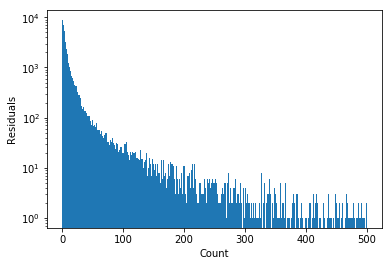

In [122]:
y_predicted = linear.predict(X_test)
residuals_histogram(y_test,y_predicted)

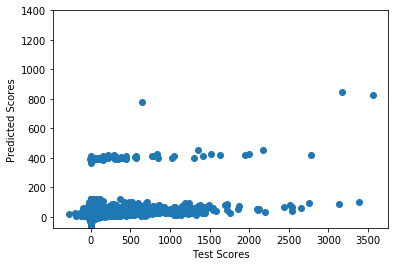

In [123]:
y_test_vs_y_predicted(y_test,y_predicted)

The last plot shows that most of the values are getting under-predicted. This is backed by the fact that the residuals plot also is skewed towards some very high values. As a result, the model has a pretty low `R-squared`, i.e., 0.07

### Lasso Regression

Let's try other versions of Linear Regression and see if at least they will make everything better. Basically, we're going to try the three popular versions:

* `Lasso Regression`
* `Ridge Regression`
* `Elastic Net Regression`

In [124]:
from sklearn.linear_model import LassoCV

In [125]:
lasso = LassoCV(cv=30).fit(X_train, y_train)
lasso.alpha_

208.9717272103955

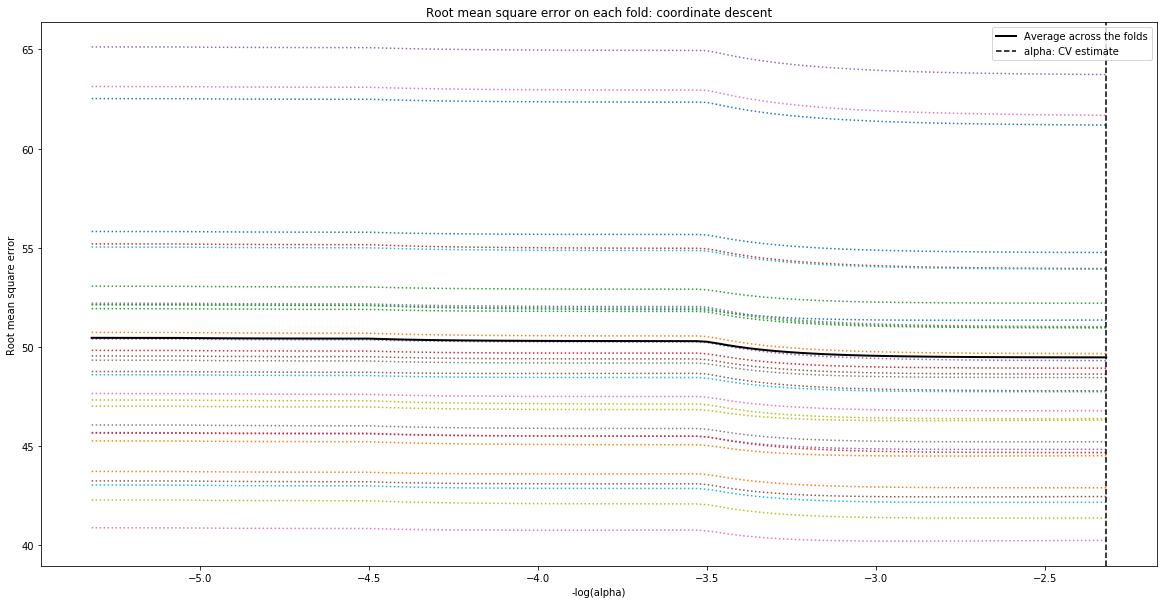

In [126]:
plot_coordinate_descent(lasso)

The coordinate descent plot for this case doesn't really give the impression that RMSEs are converging, hence, LassoCV might not help.

A quick look at the `R-squared` value will help you see that the lasso regression model actually makes things worse.

In [127]:
model_performance_dict["Lasso Regression"] = model_diagnostics(lasso)

R-Sq: 0.03778
RMSE: 49.6703409750779
MAE: 11.64411573952469


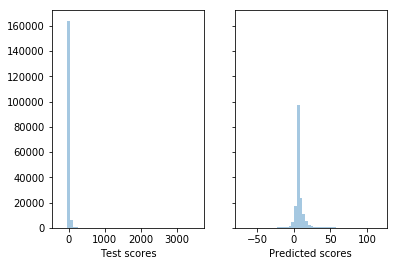

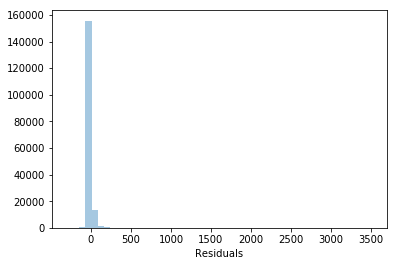

In [128]:
y_predicted = lasso.predict(X_test)
plot_residuals(y_test,y_predicted)

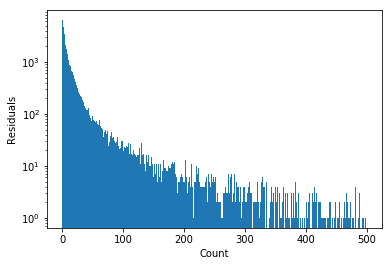

In [129]:
residuals_histogram(y_test,y_predicted)

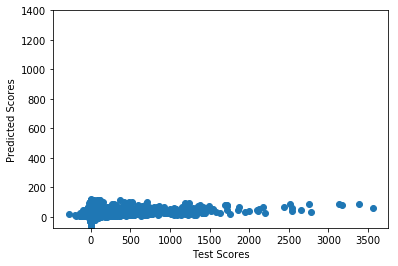

In [130]:
y_test_vs_y_predicted(y_test,y_predicted)

So the Lasso model still underpredicts, as is the case with linear regression. In fact, it loses the few points for which linear regression does a decent job, and hence loses even more in `R-squared`.

### Ridge Regression

Next, as stated earlier, we'll try Ridge Regression:

In [131]:
from sklearn.linear_model import RidgeCV

In [132]:
ridge = RidgeCV(cv=10).fit(X_train, y_train)
ridge.alpha_

10.0

In [133]:
model_performance_dict["Ridge Regression"] = model_diagnostics(ridge)

R-Sq: 0.09192
RMSE: 48.2527241470198
MAE: 11.78482265953944


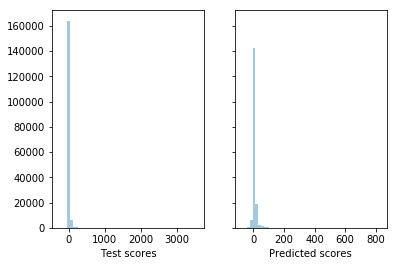

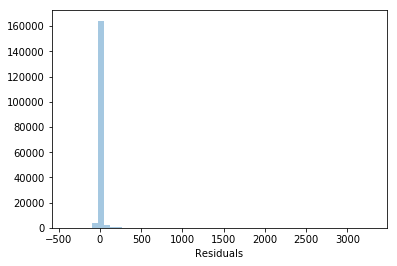

In [134]:
y_predicted = ridge.predict(X_test)
plot_residuals(y_test,y_predicted)

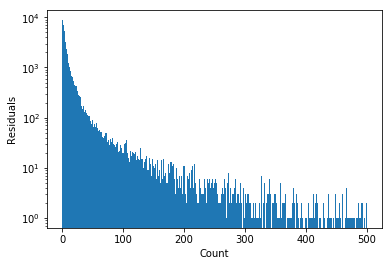

In [135]:
residuals_histogram(y_test,y_predicted)

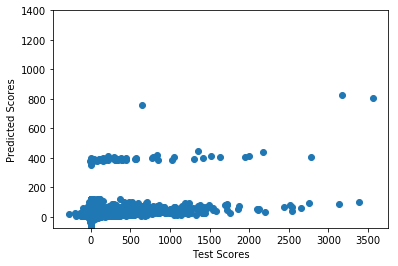

In [136]:
y_test_vs_y_predicted(y_test,y_predicted)

Risge Regression doesn't actually do any better than Linear Regression, as is shown by the above plot and by the fact that its `R-squared` value (**7.2%**) is only fractionally better than that for linear regression (**7.16%**).

### Elastic Net Regression

Let's try one last model from the linear regression family of models - Elastic Net Regression

In [137]:
from sklearn.linear_model import ElasticNetCV

In [138]:
elastic_net = ElasticNetCV(cv = 30).fit(X_train, y_train)

In [139]:
elastic_net.alpha_

417.94345442079106

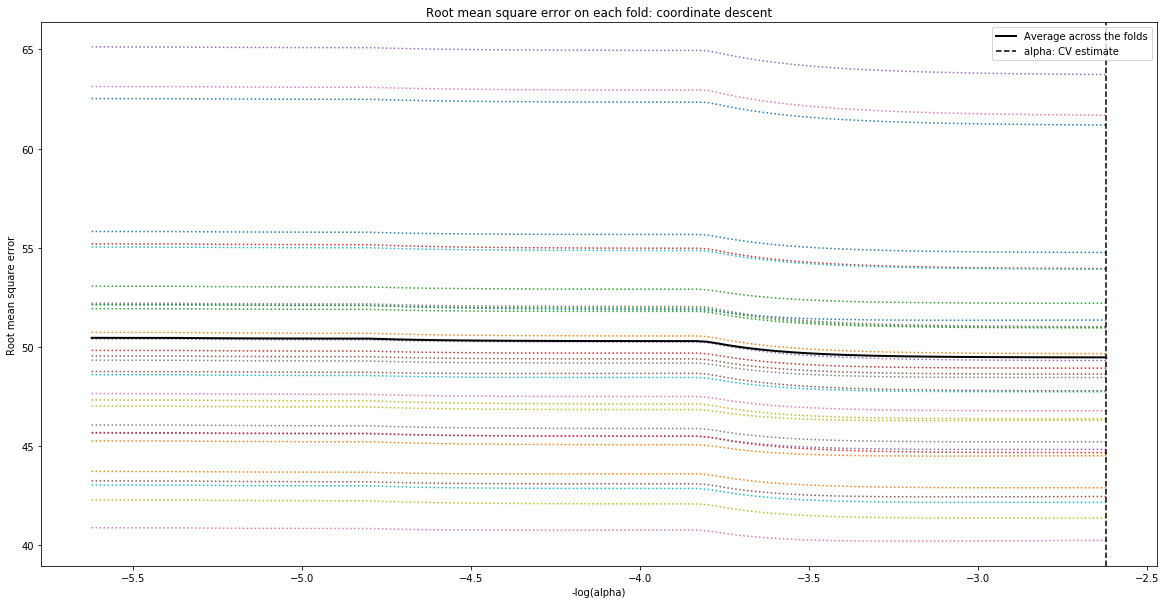

In [140]:
plot_coordinate_descent(elastic_net)

Just like Lasso regression, the coordinate descent plot here, by not convering even though it has a very high range of alphas to choose from, shows that ElasticNetCV might not really help in terms of `R-squared`.

In [141]:
model_performance_dict["Elastic Net Regression"] = model_diagnostics(elastic_net)

R-Sq: 0.03778
RMSE: 49.67044244843012
MAE: 11.643743963026571


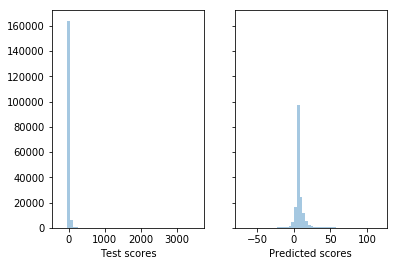

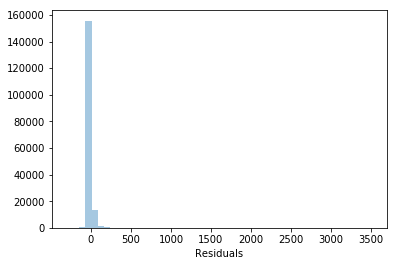

In [142]:
y_predicted = elastic_net.predict(X_test)
plot_residuals(y_test,y_predicted)

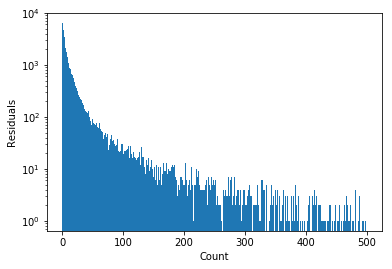

In [143]:
residuals_histogram(y_test,y_predicted)

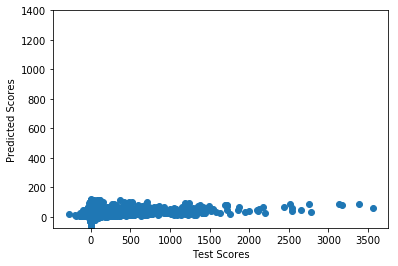

In [144]:
y_test_vs_y_predicted(y_test,y_predicted)

This model performs similarly to Lasso Regression, and hence, doesn't bring much to the table. Let's move to more complex models.

### KNN Regressor

The first non-linear model we'll fit, is KNN Regressors. Let's see how that works:

In [154]:
from sklearn.neighbors import KNeighborsRegressor

In [155]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [156]:
model_performance_dict["KNN Regression"] = model_diagnostics(knr)

R-Sq: 0.08194
RMSE: 48.517132834621464
MAE: 10.140036654255255


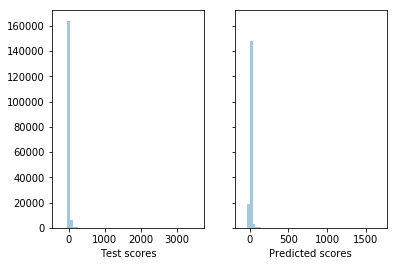

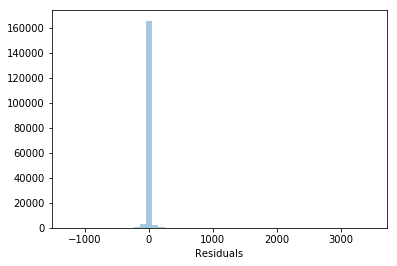

In [157]:
y_predicted = knr.predict(X_test)
plot_residuals(y_test,y_predicted)

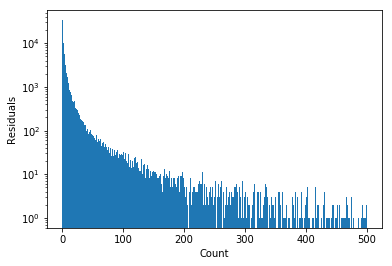

In [158]:
residuals_histogram(y_test,y_predicted)

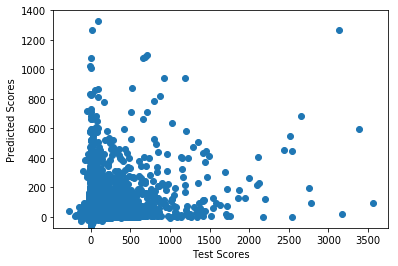

In [159]:
y_test_vs_y_predicted(y_test,y_predicted)

`R-squared` for this model is 0.1159, which is definitely a good improvement on the linear regression model's performance. The main difference between the two models is that now we actually have many more data points for which a high score is predicted.

Let's move on to tree-based models and see if they can perform better.

### Decision Tree Regression

For decision trees, we went with:
* `min_samples_leaf` = `45`
* `min_samples_split` = `45`

These numbers were chosen using cross validation. An explanation for that can be found under **Section 4: Parameter Tuning**.

In [160]:
from sklearn.tree import DecisionTreeRegressor

In [161]:
dt = DecisionTreeRegressor(min_samples_split=45, min_samples_leaf=45, random_state = 10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=45,
           min_samples_split=45, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [162]:
model_performance_dict["Decision Tree"] = model_diagnostics(dt)

R-Sq: 0.2572
RMSE: 43.64213426652361
MAE: 8.619926794113281


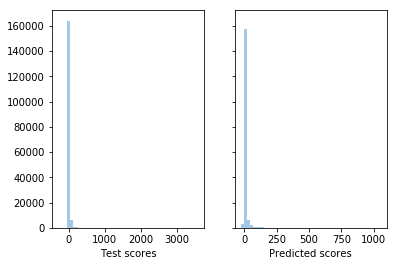

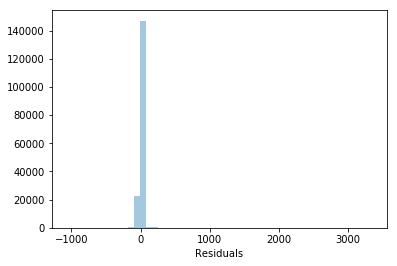

In [163]:
y_predicted = dt.predict(X_test)
plot_residuals(y_test,y_predicted)

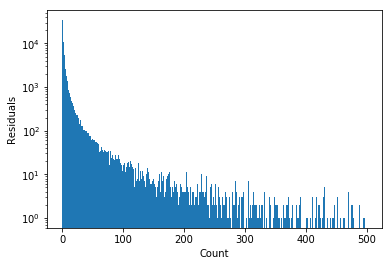

In [164]:
residuals_histogram(y_test,y_predicted)

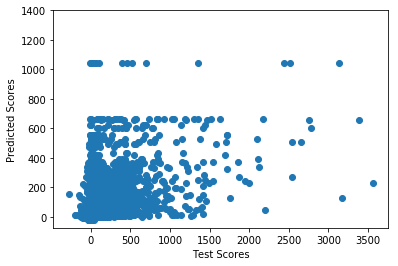

In [165]:
y_test_vs_y_predicted(y_test,y_predicted)

Decision Trees, with their inherent non-linearity are able to model this data better. They do predict higher scores for a substantial amount of the data, and that shows in the `R-squared` value (**23.53%**).

In [166]:
dt_feature_imps = get_feature_importance(dt)

parent_score                  : 30.57%
time_since_parent             : 24.80%
no_of_past_comments           : 12.12%
comment_tree_root_score       :  8.08%
gilded                        :  6.48%
time_since_comment_tree_root  :  4.11%
controversiality              :  2.94%
link_score                    :  2.40%
time_since_link               :  1.69%
title_euc                     :  1.11%
title_cosine                  :  1.03%
senti_neg                     :  0.93%
word_counts                   :  0.61%
parent_cosine                 :  0.45%
upvote_ratio                  :  0.44%
senti_comp                    :  0.40%
senti_neu                     :  0.32%
parent_euc                    :  0.28%
senti_pos                     :  0.23%
depth                         :  0.16%
hour_of_comment               :  0.12%
is_edited                     :  0.07%
weekday                       :  0.07%
no_of_linked_urls             :  0.04%
subreddit_food                :  0.03%
subjectivity             

The above gives a list of the most important features for the decision tree model. Instead of discussing these features at length here, though, we have chosen to interpret them later, for XG Boost, as that is our best performing model.

### Random Forest Regression

Parameters for Random Forest are:
* `min_samples_leaf` = `10`
* `min_samples_split` = `70`

Again, an explanation for the cross validation can be found under **Section 4: Parameter Tuning**.

In [167]:
from sklearn.ensemble import RandomForestRegressor

In [168]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [169]:
model_performance_dict["Random Forest"] = model_diagnostics(rf)

R-Sq: 0.3184
RMSE: 41.805077396832175
MAE: 8.18011902715427


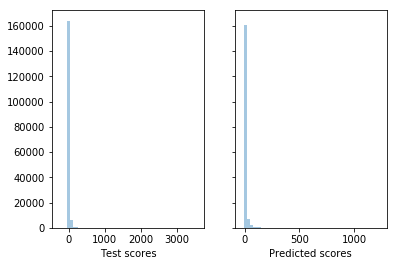

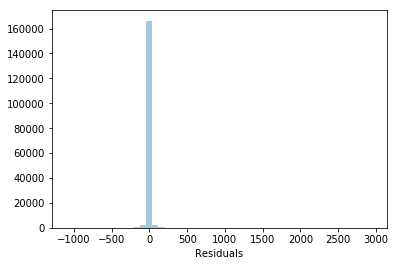

In [170]:
y_predicted = rf.predict(X_test)
plot_residuals(y_test,y_predicted)

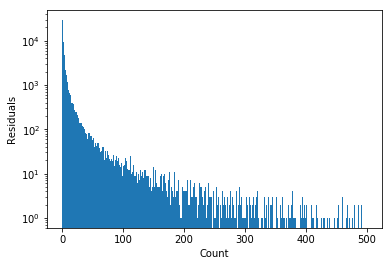

In [171]:
residuals_histogram(y_test,y_predicted)

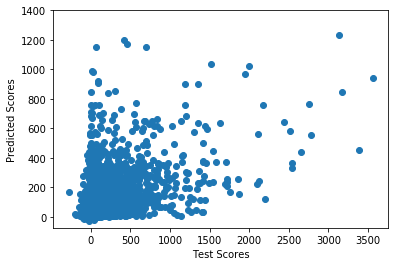

In [172]:
y_test_vs_y_predicted(y_test,y_predicted)

Random Forests's scatter plot looks pretty much the same as the one for Decision Trees, except for one fact: Decision Trees were predicting high values for quite a few comments that were supposed to get low values, but Random Forests succeed in avoiding that and hence, have a greater `R-squared` value (**30.7%**).

In [173]:
rf_feature_imps = get_feature_importance(rf)

parent_score                  : 23.42%
time_since_parent             : 18.54%
no_of_past_comments           : 11.11%
comment_tree_root_score       :  7.13%
gilded                        :  5.75%
link_score                    :  3.59%
time_since_comment_tree_root  :  3.26%
time_since_link               :  3.07%
title_cosine                  :  2.64%
title_euc                     :  2.47%
parent_cosine                 :  2.13%
parent_euc                    :  2.13%
word_counts                   :  2.13%
controversiality              :  2.13%
senti_comp                    :  1.68%
senti_neu                     :  1.54%
senti_neg                     :  1.30%
upvote_ratio                  :  1.20%
senti_pos                     :  1.12%
depth                         :  0.35%
hour_of_comment               :  0.26%
subjectivity                  :  0.24%
is_edited                     :  0.22%
is_selftext                   :  0.22%
subreddit_food                :  0.17%
is_flair_css             